오늘은 **Object Detection** 분야의 2-stage detectr의 논문의 기본이 되는 **R-CNN**에 대하여 구현을 해보겠습니다. <br>
- 논문은 **Rich feature jierarchies object detection and semantic segmentation** (https://arxiv.org/pdf/1311.2524.pdf) 입니다.<br>
- 코드 구현은 https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55 에서 참고하였습니다.

R-CNN은 다음과 같은 시스템으로 구성되어 있습니다.

먼저,<br>
**(1) 이미지를 넣습니다.<br>
(2) 2000개 이하의 region proposals를 추출합니다.<br>
(3) CNN을 이용해 각각 proposal에서 features를 계산합니다.<br>
(4) class별 선형 SVMs을 이용하여 각각 region을 분류합니다.**<br>

- ILSVRC2013 detection dataset에서는 31.4%가 나왔는데 낮은 숫자라고 볼 수 있지만 이전 다른 모형인 OverFeat의 좋은 결과가 24.3%였으니 크게 개선된 것이라고 할 수 있습니다.

*그럼 함께 구현하러 가보겠습니다.*

### 1) 데이터 불러오기

- images 폴더 안에는 비행기가 포함된 이미지들이 있습니다.<br>
- Airplanes_Annotations 폴더 안에는 bounding box 값과 비행기 갯수가 적혀 있는 csv 파일이 있습니다.


In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
path = "Images"
annot = "Airplanes_Annotations"

42845.jpg


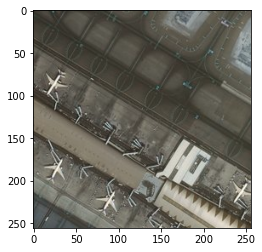

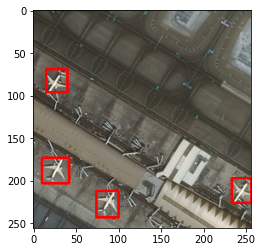

In [3]:
# 하나의 이미지 위에 바운딩 박스 표시
for i in os.listdir(annot):
    filename = i.split(".")[0]+".jpg"
    print(filename)
    img = cv2.imread(os.path.join(path,filename))
    df = pd.read_csv(os.path.join(annot,i))
    plt.imshow(img)
    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
    plt.figure()
    plt.imshow(img)
    break

- **listdir()**<br>
listdir()은 파일안 목록을 보는 함수입니다.

위 코드는 먼저 filename을 jpg로 다 바꾸고 filename, img, img에 bounding box를 그린 img를 출력하는 코딩입니다.

### 2) Region Proposal 추출하기


- 여기에서는 region proposal을 추출하는 단계입니다. selectivesearch 패키지의 selective_search를 이용하여 region proposal을 추출합니다.

- **Selective Search 알고리즘**<br>
Selective Search는 object 인식이나 검출을 위한 가능한 region proposal을 알아낼 수 있는 방법을 제공하는 것을 목표로 하는 알고리즘입니다. 

**1)** 먼저 입력 영상에 대하여 segmentation을 실시해 이를 기반으로 region proposal을 찾기 위해 seed를 설정합니다.<br>
**2)** 엄청나게 많은 region proposal이 만들어집니다.<br>
**3)** 이를 greedy 알고리즘을 사용하여 작은 영역을 큰 영역으로 결합시켜나가면 segmentation은 region proposal 개수가 줄어듭니다.<br>


In [4]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

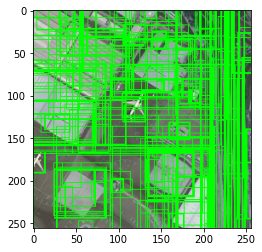

In [5]:
# 42850.jpg 이미지 예시
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect 
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1)
# plt.figure()
plt.imshow(imOut)

- **cv2.setUseOptimized()**<br>
활성화되면 최적화된 코드를 실행하고 그렇지 않으면 활성화되지 않은 코드를 실행하는 코드입니다. True이기 때문에 활성화를 합니다.
- **ss.cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()**<br>
기본 매개변수를 사용하여 selective search segmentation 개체를 만드는 코드입니다.

- **ss.setBaseImage()**<br>
segmentation을 실행할 입력 이미지를 설정합니다.

- **ss.switchToSelectiveSearchFast()**<br>
빠르지만 회수율이 낮은 방식으로 selective search

- **ss.process()**<br>
입력 이미지에 selective search segmentation 실행

위 과정을 수행하고 난 후 bounding box값을 받아와 rectangle을 이용하여 사각형을 그립니다.
- **cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)**<BR>
retangle은 사각형을 그리는 함수입니다. (x,y)는 왼쪽 위 점을 (x+w,y+h)는 오른쪽 아래 점을 나타냅니다.(0,255,0)은 RGB color중 Green color를 이용하여 사각형을 그리겠다는 의미이고 thickness 선 두께를 나타냅니다. 
    

### 3) IOU 정의하기

**IOU(Intersection over Union)**는 물체의 위치를 나타내는 bounding box가 얼마나 일치하는지를 수학적으로 나타내는 지표입니다. 실제 물체의 위치와 예측 물체의 위치를 평가하는 방법입니다. IOU 계산은 교집합/합집합으로 하면 됩니다.

In [9]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top) # 교집합

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # 교집합 / 합집합
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area) 
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

- **assert** <br>
가정 설명문으로 뒤의 조건이 True가 아니면 AssertError가 발생하는 함수

- **get_iou** <br>
bounding box의 좌표 값의 겹치는 부분을 계산하여 iou값을 계산하는 함수를 정의합니다.
이때 교집합 / 합집합이기 때문에 값의 범위는 0 ~ 1 사이입니다.

### 4) train img, label 구분

In [10]:
train_images=[]
train_labels=[]

In [11]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [12]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

17 airplane_001.jpg
inside
18 airplane_002.jpg
19 airplane_003.jpg
20 airplane_004.jpg
inside
21 airplane_005.jpg
inside
22 airplane_006.jpg
23 airplane_007.jpg
inside
24 airplane_008.jpg
25 airplane_009.jpg
26 airplane_010.jpg
27 airplane_011.jpg
28 airplane_012.jpg
inside
29 airplane_013.jpg
30 airplane_014.jpg
31 airplane_015.jpg
32 airplane_016.jpg
33 airplane_017.jpg
34 airplane_018.jpg
35 airplane_019.jpg
36 airplane_020.jpg
37 airplane_021.jpg
38 airplane_022.jpg
39 airplane_023.jpg
40 airplane_024.jpg
41 airplane_025.jpg
42 airplane_026.jpg
43 airplane_027.jpg
44 airplane_028.jpg
45 airplane_029.jpg
46 airplane_030.jpg
47 airplane_031.jpg
48 airplane_032.jpg
49 airplane_033.jpg
50 airplane_034.jpg
51 airplane_035.jpg
52 airplane_036.jpg
53 airplane_037.jpg
54 airplane_038.jpg
55 airplane_039.jpg
56 airplane_040.jpg
57 airplane_041.jpg
inside
58 airplane_042.jpg
59 airplane_043.jpg
60 airplane_044.jpg
61 airplane_045.jpg
inside
62 airplane_046.jpg
63 airplane_047.jpg
64 airplane

396 airplane_380.jpg
397 airplane_381.jpg
398 airplane_382.jpg
inside
399 airplane_383.jpg
inside
400 airplane_384.jpg
401 airplane_385.jpg
inside
402 airplane_386.jpg
403 airplane_387.jpg
404 airplane_388.jpg
inside
405 airplane_389.jpg
406 airplane_390.jpg
407 airplane_391.jpg
408 airplane_392.jpg
409 airplane_393.jpg
410 airplane_394.jpg
411 airplane_395.jpg
412 airplane_396.jpg
413 airplane_397.jpg
414 airplane_398.jpg
415 airplane_399.jpg
416 airplane_400.jpg
417 airplane_401.jpg
418 airplane_402.jpg
419 airplane_403.jpg
420 airplane_404.jpg
421 airplane_405.jpg
422 airplane_406.jpg
423 airplane_407.jpg
424 airplane_408.jpg
425 airplane_409.jpg
426 airplane_410.jpg
427 airplane_411.jpg
428 airplane_412.jpg
429 airplane_413.jpg
430 airplane_414.jpg
431 airplane_415.jpg
432 airplane_416.jpg
433 airplane_417.jpg
434 airplane_418.jpg
435 airplane_419.jpg
inside
436 airplane_420.jpg
437 airplane_421.jpg
438 airplane_422.jpg
439 airplane_423.jpg
440 airplane_424.jpg
441 airplane_425.jpg

- ss 부분은 앞 부분이랑 똑같습니다.
- 그 뒤에 알고리즘은 다음과 같습니다. 하나의 이미지에 많은 배경 샘플과 Object 샘플이 있을 수 있으므로 Object와 배경의 비율을 비슷하게 맞추기 위해 counter와 falsecounter의 값을 30으로 제안하여 region proposal을 설정하였습니다.
- iou 값을 기준으로 0.7 초과이면 그 region을 Object 즉, 비행기의 라벨인 1로 라벨링하게 하고 region 이미지의 크기를 resize해 전부 같게 만들어주었습니다.
- 반대로 iou 값을 기준으로 0.3 미만이면 그 region을 배경 즉, 라벨이 0으로 라벨링하게 하고 region 이미지의 크기를 resize해 전부 같게 만들어주었습니다.


In [13]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [14]:
print(X_new.shape)
print(y_new.shape)

(30229, 224, 224, 3)
(30229,)


다음과 같은 과정을 거쳐 나온 X_new와 y_new의 shape는 다음과 같습니다. 논문에서는 2000개 정도 뽑았는데 여기에서는  e < 2000 and flag == 0 조건을 추가하여 30229개의 region이 X_new 값으로 들어간 것을 확인하였습니다.

### 5) 모델링

pretrained model인 VGG16을 사용하여 분류합니다.

In [15]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [16]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

사전에 학습된 네트워크의 표현을 그대로 사용해서 적용하려는 이미지의 feature을 뽑아내는 작업을 합니다. 이를 feature extract라고 합니다.

In [17]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

- **trainable = False** <br>
layers.trainable를 False로 설정하면 모든 레이어의 가중치가 훈련 가능에서 훈련 불가능으로 이동합니다. 이를 레이어 동결이라고 합니다. 이를 쓰게 되면 앞에 15개의 layer만 빼고 학습이 된다는 뜻입니다.

In [18]:
X = vggmodel.layers[-2].output

In [19]:
predictions = Dense(2, activation="softmax")(X)

In [20]:
vggmodel.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [21]:
model_final = Model(vggmodel.input,predictions)

In [22]:
# Optimizer 설정
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

In [23]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [24]:
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

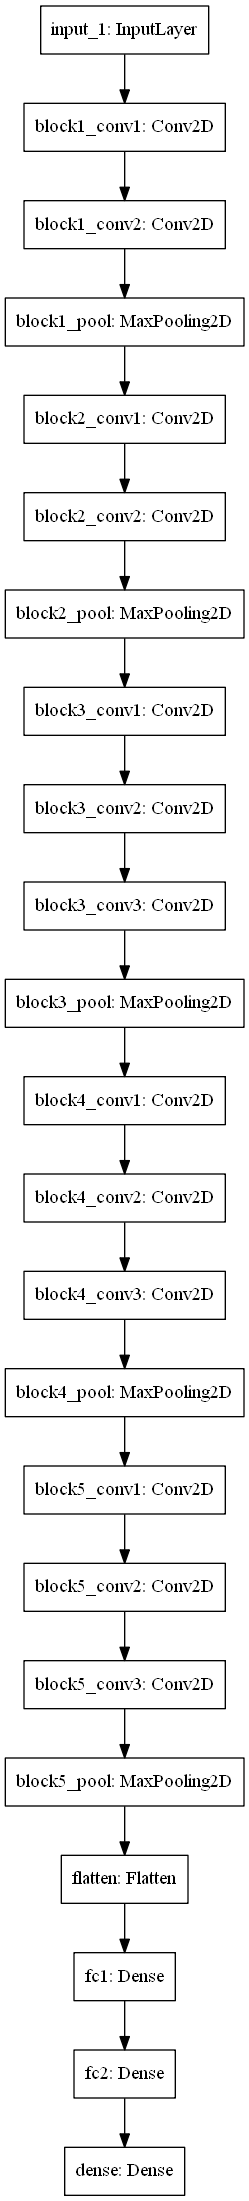

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model_final, to_file='vgg.png')

- vgg16 모형에 마지막 부분만 바꿔주고 **윗 부분 weights를 고정**시켰습니다.
- Optimizer는 **Adam**으로 loss는 **categorical_cross_entropy**로 설정하고 판단 척도로 **accuracy**를 설정하여 compile 해주었습니다.
- 논문에서는 CNN을 이용하여 feature을 뽑은 후 linear SVMs를 이용하였는데 위 코드에서는 두 개를 합쳐 vgg16 모형을 변형하여 바로 Object인지 배경인지를 분류하였습니다.

### 6) 모형에 들어가는 X,y 전처리 후 train, test 분리

In [26]:
y_new

array([0, 0, 0, ..., 1, 1, 1])

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [28]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [29]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [30]:
Y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

- label에 대하여 **원-핫 인코딩**을 합니다. 원-핫 인코딩은 한 개의 요소를 True(1) 나머지 요소는 Falsse(0)으로 만들어주는 기법입니다.
- 위 y_new에 대하여 **LabelBinarizer**를 이용하여 0,1 값을 [0,1], [1,0] 값으로 바꿔주었습니다.

In [31]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.1)

In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(27206, 224, 224, 3)
(3023, 224, 224, 3)
(27206, 2)
(3023, 2)


In [33]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

- **Keras ImageDataGenerator**<br>
데이터 값을 늘리기 위해 horizontal_flip(수평 뒤집기), vertical_flip(수직 뒤집기), rotation(회전) 등을 수행하여 argumentation(증대) 작업을 수행합니다.

### 7) 모형 학습

In [34]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [35]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

- val_loss를 기준으로 100회동안 큰 변화가 없다면 조기 종료를 시켜주는 **EarlyStopping**

In [36]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 100, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

C:\Users\HeoJiHae\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 64s 6s/step - loss: 1.9380 - accuracy: 0.6465 - val_loss: 0.5218 - val_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 0.52176, saving model to ieeercnn_vgg16_1.h5
Epoch 2/100
10/10 [==============================] - 58s 6s/step - loss: 0.3966 - accuracy: 0.8326 - val_loss: 0.2381 - val_accuracy: 0.9062

Epoch 00002: val_loss improved from 0.52176 to 0.23809, saving model to ieeercnn_vgg16_1.h5
Epoch 3/100
10/10 [==============================] - 58s 6s/step - loss: 0.2406 - accuracy: 0.9101 - val_loss: 0.3695 - val_accuracy: 0.8906

Epoch 00003: val_loss did not improve from 0.23809
Epoch 4/100
10/10 [==============================] - 58s 6s/step - loss: 0.1472 - accuracy: 0.9488 - val_loss: 0.2626 - val_accuracy: 0.8750

Epoch 00004: val_loss did not improve from 0.23809
Epoch 5/100
10/10 [==============================] - 58s 6s/step - loss: 0.2533 - accuracy: 0.9163 - val_loss: 0.2752 - val_accuracy: 0.8438

Epoch 00

10/10 [==============================] - 57s 6s/step - loss: 0.1810 - accuracy: 0.9432 - val_loss: 0.1644 - val_accuracy: 0.9219

Epoch 00042: val_loss did not improve from 0.06938
Epoch 43/100
10/10 [==============================] - 57s 6s/step - loss: 0.2168 - accuracy: 0.8983 - val_loss: 0.0905 - val_accuracy: 0.9688

Epoch 00043: val_loss did not improve from 0.06938
Epoch 44/100
10/10 [==============================] - 57s 6s/step - loss: 0.1463 - accuracy: 0.9483 - val_loss: 0.0879 - val_accuracy: 0.9531

Epoch 00044: val_loss did not improve from 0.06938
Epoch 45/100
10/10 [==============================] - 57s 6s/step - loss: 0.2103 - accuracy: 0.9314 - val_loss: 0.0769 - val_accuracy: 0.9844

Epoch 00045: val_loss did not improve from 0.06938
Epoch 46/100
10/10 [==============================] - 57s 6s/step - loss: 0.1683 - accuracy: 0.9310 - val_loss: 0.2039 - val_accuracy: 0.9219

Epoch 00046: val_loss did not improve from 0.06938
Epoch 47/100
10/10 [=======================

10/10 [==============================] - 57s 6s/step - loss: 0.1493 - accuracy: 0.9258 - val_loss: 0.1026 - val_accuracy: 0.9688

Epoch 00084: val_loss did not improve from 0.04489
Epoch 85/100
10/10 [==============================] - 58s 6s/step - loss: 0.1360 - accuracy: 0.9584 - val_loss: 0.1731 - val_accuracy: 0.9219

Epoch 00085: val_loss did not improve from 0.04489
Epoch 86/100
10/10 [==============================] - 57s 6s/step - loss: 0.1660 - accuracy: 0.9553 - val_loss: 0.2614 - val_accuracy: 0.9531

Epoch 00086: val_loss did not improve from 0.04489
Epoch 87/100
10/10 [==============================] - 57s 6s/step - loss: 0.1469 - accuracy: 0.9359 - val_loss: 0.2003 - val_accuracy: 0.9219

Epoch 00087: val_loss did not improve from 0.04489
Epoch 88/100
10/10 [==============================] - 57s 6s/step - loss: 0.1339 - accuracy: 0.9600 - val_loss: 0.2215 - val_accuracy: 0.9375

Epoch 00088: val_loss did not improve from 0.04489
Epoch 89/100
10/10 [=======================

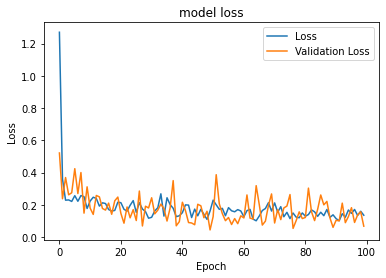

<Figure size 432x288 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

학습 결과 loss 값이 점차적으로 잘 줄어드는 것을 확인했습니다 :)

### 8) 테스트 결과

In [42]:
out= model_final.predict(img)
out.shape

(1, 2)

In [43]:
out

array([[0.79348475, 0.20651528]], dtype=float32)

plane


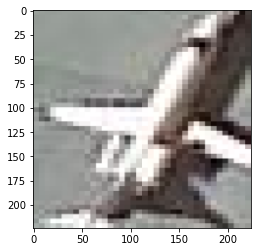

In [38]:
im = X_test[1600]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

- **np.expand_dims**<br>
배열에 차원 추가하는 함수입니다. 따라서 원래 있던 im의 shape는 (224,224,3) 이었는데 expand_dims 함수를 통해 첫번째 축에 (1,224,224,3)의 shape을 가지게 됨을 알 수 있습니다.

그 후 학습된 모형에 input값을 넣어 출력된 out은 **두 가지 값**을 가지고 있습니다. 여기서 첫번째 값이 두번째 값보다 **크다면** [1,0]의 라벨을 얻을 수 있으므로 비행기라고 분류할 수 있고 첫번째 값이 두번째 값보다 **작다면** [0,1]의 라벨을 얻을 수 있으므로 배경이라고 분류할 수 있습니다.

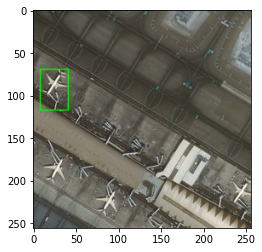

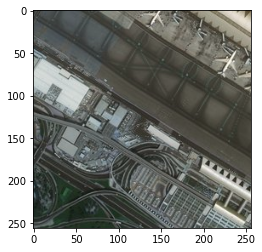

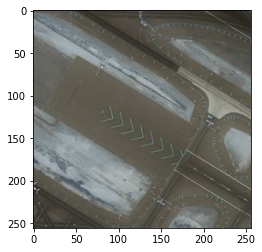

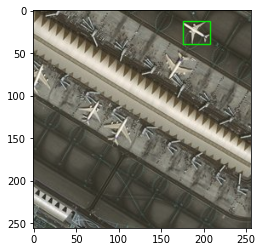

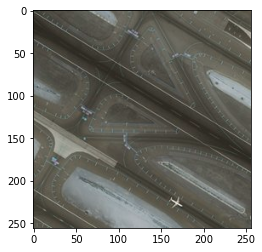

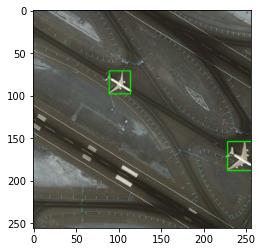

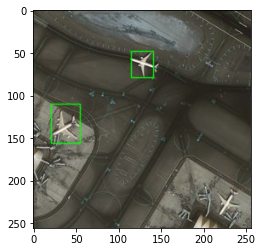

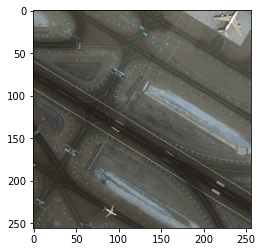

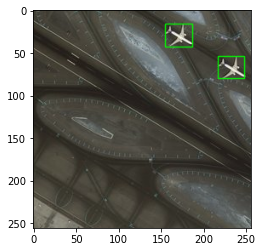

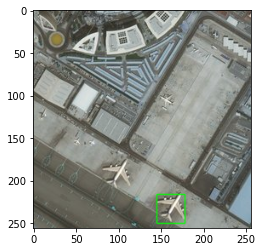

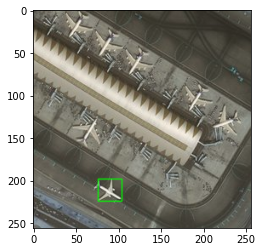

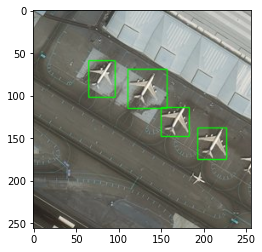

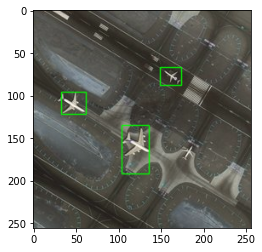

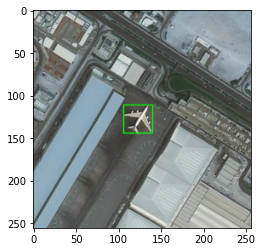

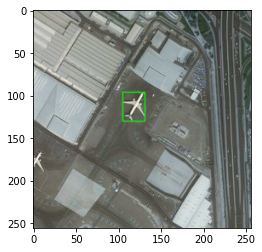

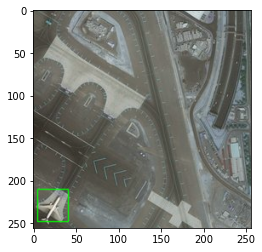

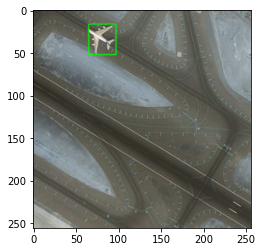

In [39]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)

앞과 똑같은 과정을 거쳐 시각화를 하였습니다.

### [결론]

- vgg16을 이용하여 물체(비행기)와 배경을 나름 잘 detection한 것을 확인하였습니다. 

### [고찰]

- 컴퓨터 사양이 엄청 뛰어나지 않아서 조금 더 많은 데이터로 학습을 시키려고 하니 메모리 에러가 떴습니다 ㅠㅠ 아숩,,
- 마찬가지로 epoch도 더 많이 학습을 시켰더라면 더 좋은 결과가 나오지 않을까 싶습니다.
- 위 데이터에서 feature만 뽑아내서 SVM으로도 한 번 시도해보겠습니다.
- VOC 2007 이미지를 이용해서 R-CNN OD를 시도했는데 bounding box를 예측하지 못하는 것을 확인했습니다. ㅠㅠ 조금 더 시도해서 된다면 코드 공유를 해보겠습니다.

### [Reference]

[1] R-CNN :
https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55<br>
[2] R-CNN 참고 : https://velog.io/@rockgoat2/Object-Detection-RCNN-%EB%A6%AC%EB%B7%B0-Python%EC%97%90%EC%84%9C%EC%9D%98-%EA%B5%AC%ED%98%84 <BR>
[3] Selective Search 알고리즘 정의 :
https://better-tomorrow.tistory.com/entry/Selective-Search-%EA%B0%84%EB%8B%A8%ED%9E%88-%EC%A0%95%EB%A6%AC?category=488291?category=488291<br>
[4] IOU 정의 :
https://minimin2.tistory.com/144 <br>
[5] plot_model 에러 : <vr>
https://twinstarinfo.blogspot.com/2019/05/pydot-install.html